In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle-2.json to kaggle-2.json


{'kaggle-2.json': b'{"username":"alihasankhan","key":"1be087b442327179f9619f37fcc1f755"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 /content/Kaggle/kaggle-2.json

chmod: cannot access '/content/Kaggle/kaggle-2.json': No such file or directory


In [ ]:
! /content/Kaggle/kaggle-2.json datasets list

/bin/bash: line 1: /content/Kaggle/kaggle-2.json: No such file or directory


In [ ]:
!pip install -q opendatasets

import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset') # insert ypu kaggle  username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: alihasankhan
Your Kaggle Key: ··········


100%|██████████| 3.79G/3.79G [00:43<00:00, 93.5MB/s]


In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
!pip install -q -U segmentation-models-pytorch==0.2.0 albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
DATA_DIR = '/content/deepglobe-road-extraction-dataset'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df.head()

image_id  split        sat_image_path              mask_path
0    100034  train  train/100034_sat.jpg  train/100034_mask.png
1    100081  train  train/100081_sat.jpg  train/100081_mask.png
2    100129  train  train/100129_sat.jpg  train/100129_mask.png
3    100703  train  train/100703_sat.jpg  train/100703_mask.png
4    100712  train  train/100712_sat.jpg  train/100712_mask.png

In [ ]:
metadata_df_train = metadata_df[metadata_df['split']=='train']
metadata_df_train = metadata_df_train[['image_id', 'sat_image_path', 'mask_path']]
metadata_df_train['sat_image_path'] = metadata_df_train['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df_train['mask_path'] = metadata_df_train['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df_train.head()
# This sample code give actual path to all the train data satellite and masked images.

image_id                                     sat_image_path  \
0    100034  /content/deepglobe-road-extraction-dataset/tra...   
1    100081  /content/deepglobe-road-extraction-dataset/tra...   
2    100129  /content/deepglobe-road-extraction-dataset/tra...   
3    100703  /content/deepglobe-road-extraction-dataset/tra...   
4    100712  /content/deepglobe-road-extraction-dataset/tra...   

                                           mask_path  
0  /content/deepglobe-road-extraction-dataset/tra...  
1  /content/deepglobe-road-extraction-dataset/tra...  
2  /content/deepglobe-road-extraction-dataset/tra...  
3  /content/deepglobe-road-extraction-dataset/tra...  
4  /content/deepglobe-road-extraction-dataset/tra...

In [ ]:
metadata_df_train.shape

(6226, 3)

In [ ]:
metadata_df_train = metadata_df_train.sample(frac=1).reset_index(drop=True)
# Above line is shuffling all the rows present in dataFrame.
# frac =1 means all rows

valid_df = metadata_df_train.sample(frac=0.1, random_state=42)
train_df = metadata_df_train.drop(valid_df.index)
len(train_df), len(valid_df)

(5603, 623)

In [ ]:
train_df.head()

image_id                                     sat_image_path  \
0    174781  /content/deepglobe-road-extraction-dataset/tra...   
1    278054  /content/deepglobe-road-extraction-dataset/tra...   
2    800523  /content/deepglobe-road-extraction-dataset/tra...   
3    878598  /content/deepglobe-road-extraction-dataset/tra...   
4    839603  /content/deepglobe-road-extraction-dataset/tra...   

                                           mask_path  
0  /content/deepglobe-road-extraction-dataset/tra...  
1  /content/deepglobe-road-extraction-dataset/tra...  
2  /content/deepglobe-road-extraction-dataset/tra...  
3  /content/deepglobe-road-extraction-dataset/tra...  
4  /content/deepglobe-road-extraction-dataset/tra...

In [ ]:
valid_df.head()

image_id                                     sat_image_path  \
239      18781  /content/deepglobe-road-extraction-dataset/tra...   
1119    586070  /content/deepglobe-road-extraction-dataset/tra...   
2215    400636  /content/deepglobe-road-extraction-dataset/tra...   
2500    384296  /content/deepglobe-road-extraction-dataset/tra...   
5783    614192  /content/deepglobe-road-extraction-dataset/tra...   

                                              mask_path  
239   /content/deepglobe-road-extraction-dataset/tra...  
1119  /content/deepglobe-road-extraction-dataset/tra...  
2215  /content/deepglobe-road-extraction-dataset/tra...  
2500  /content/deepglobe-road-extraction-dataset/tra...  
5783  /content/deepglobe-road-extraction-dataset/tra...

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
class_dict.head()

name    r    g    b
0        road  255  255  255
1  background    0    0    0

In [ ]:
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [ ]:
select_classes = ['background', 'road']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [ ]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [ ]:
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [ ]:
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

In [ ]:
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class RoadsDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)

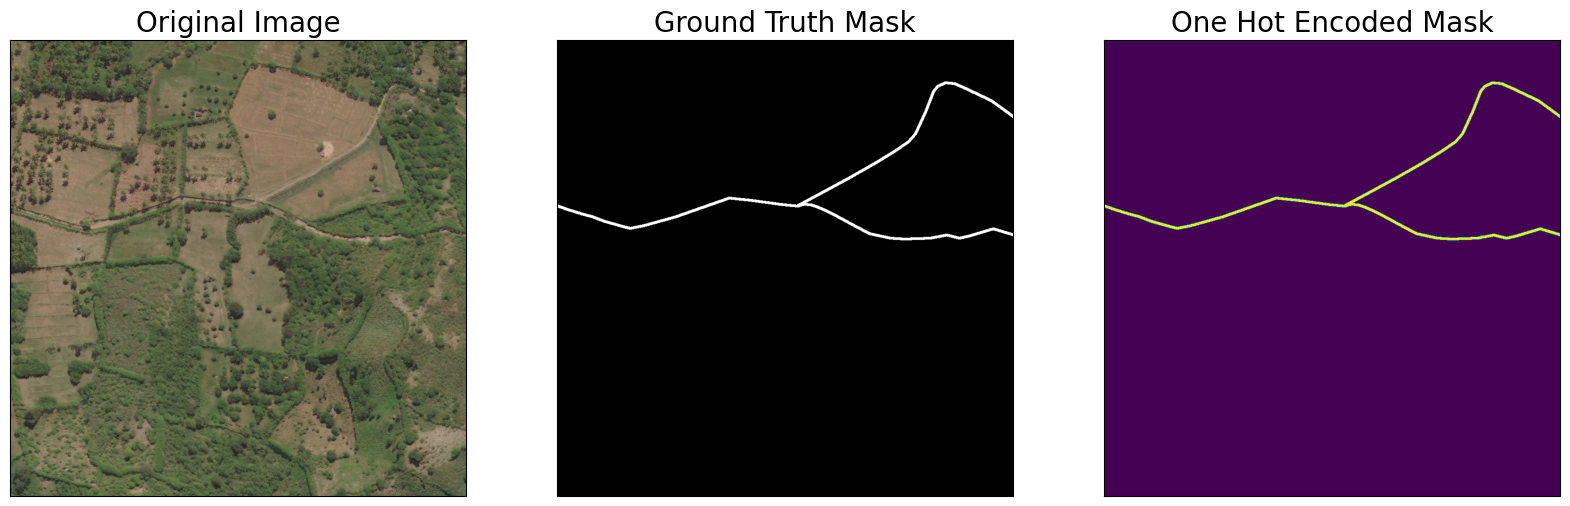

In [ ]:
dataset = RoadsDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [ ]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)

In [ ]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [ ]:
def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

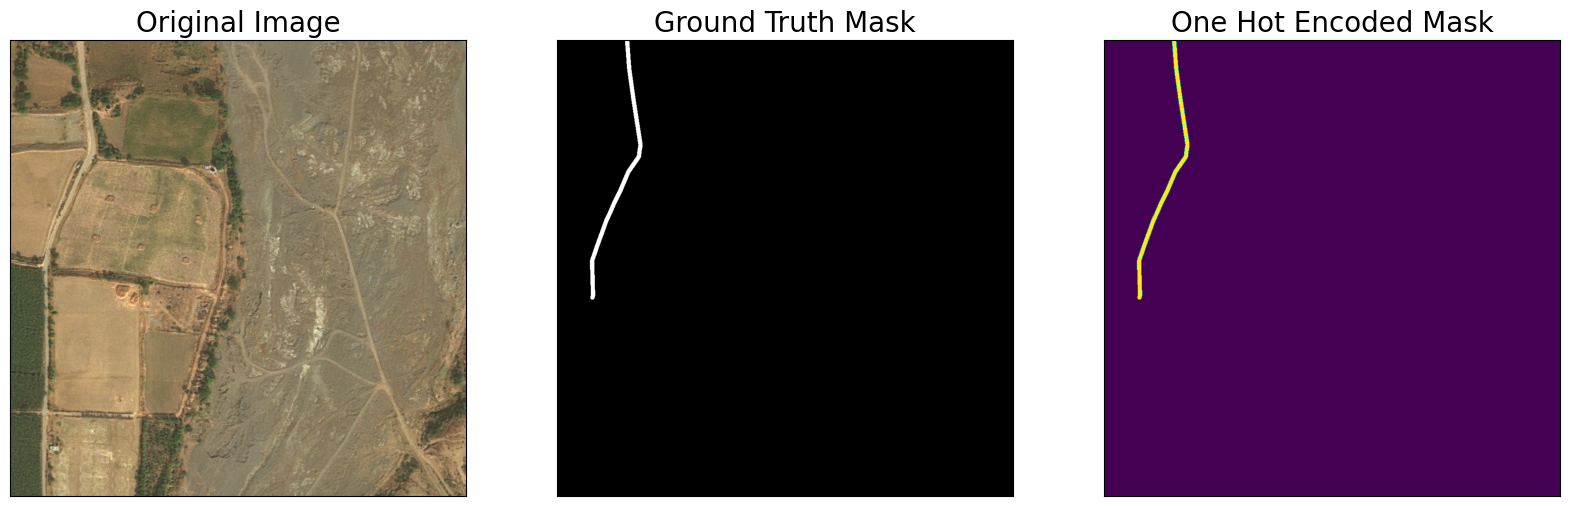

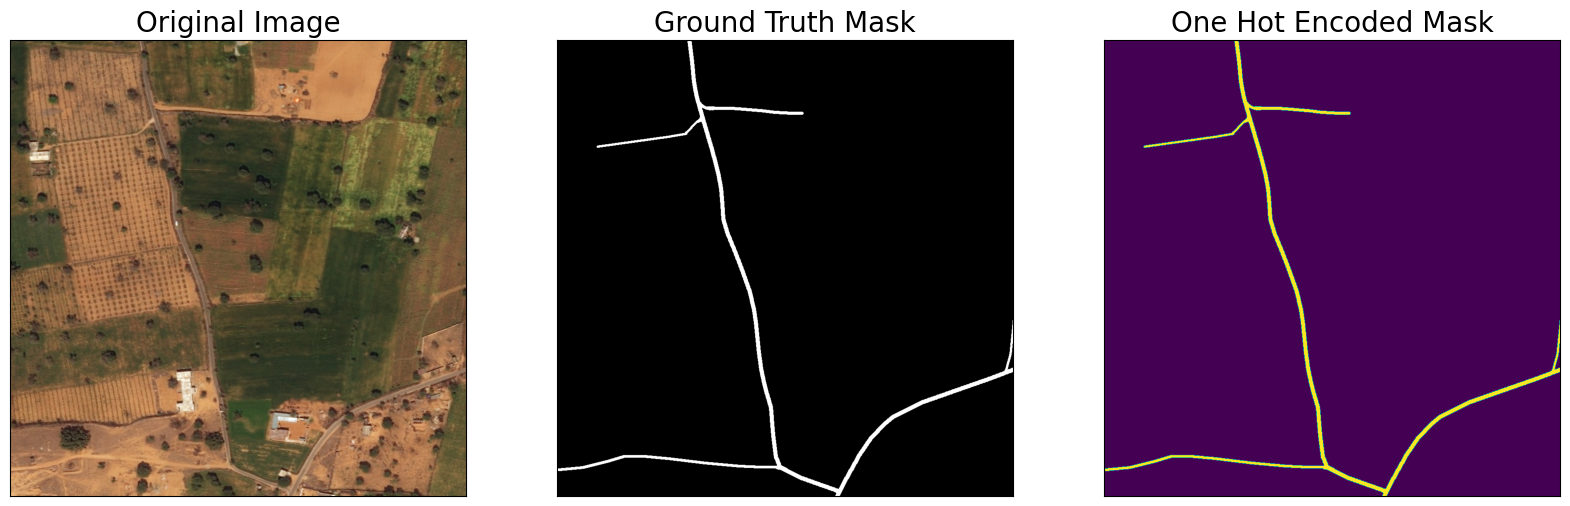

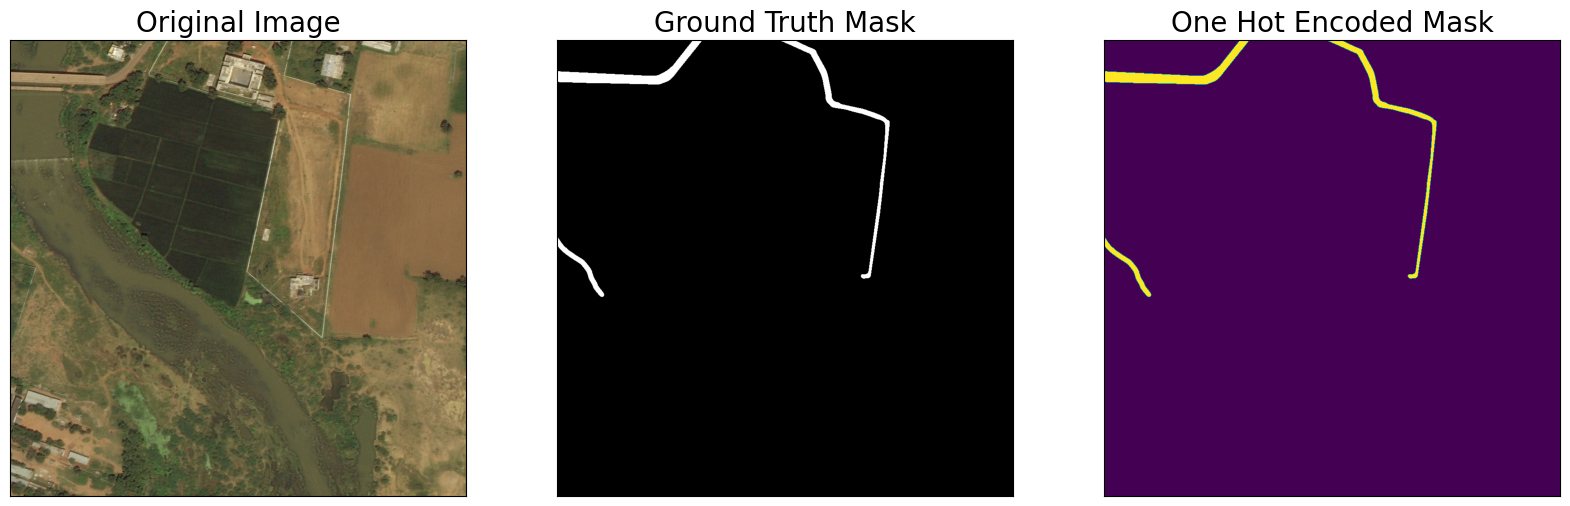

In [ ]:
for idx in range(3):
    image, mask = dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

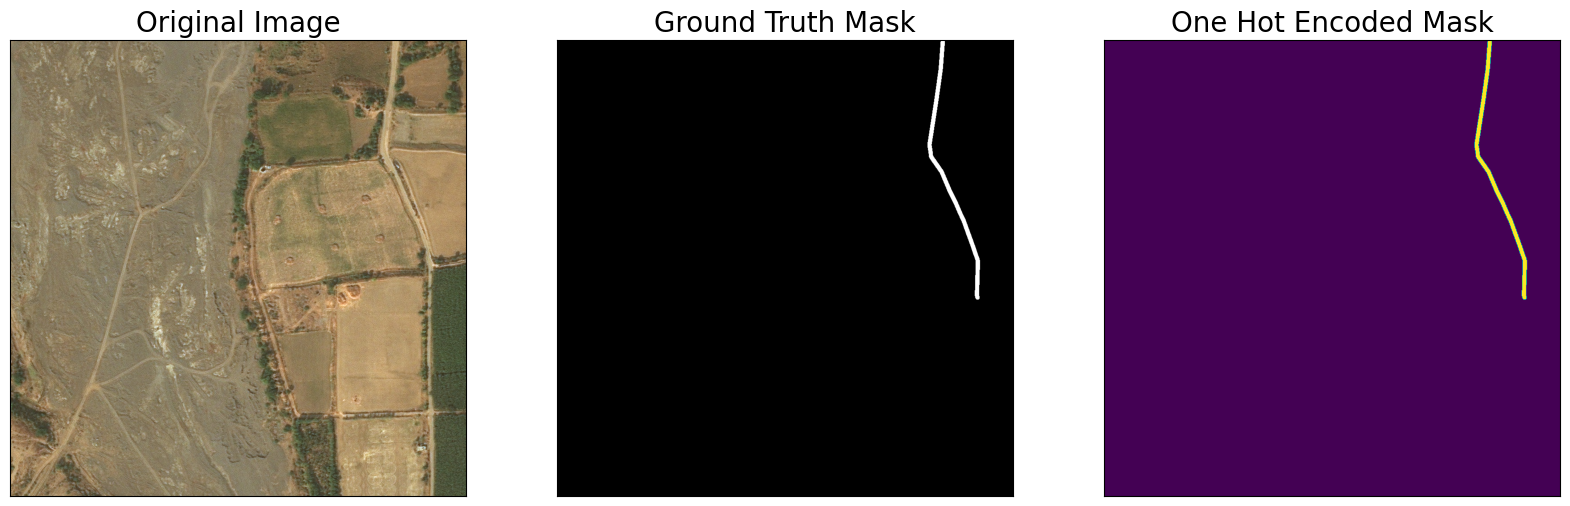

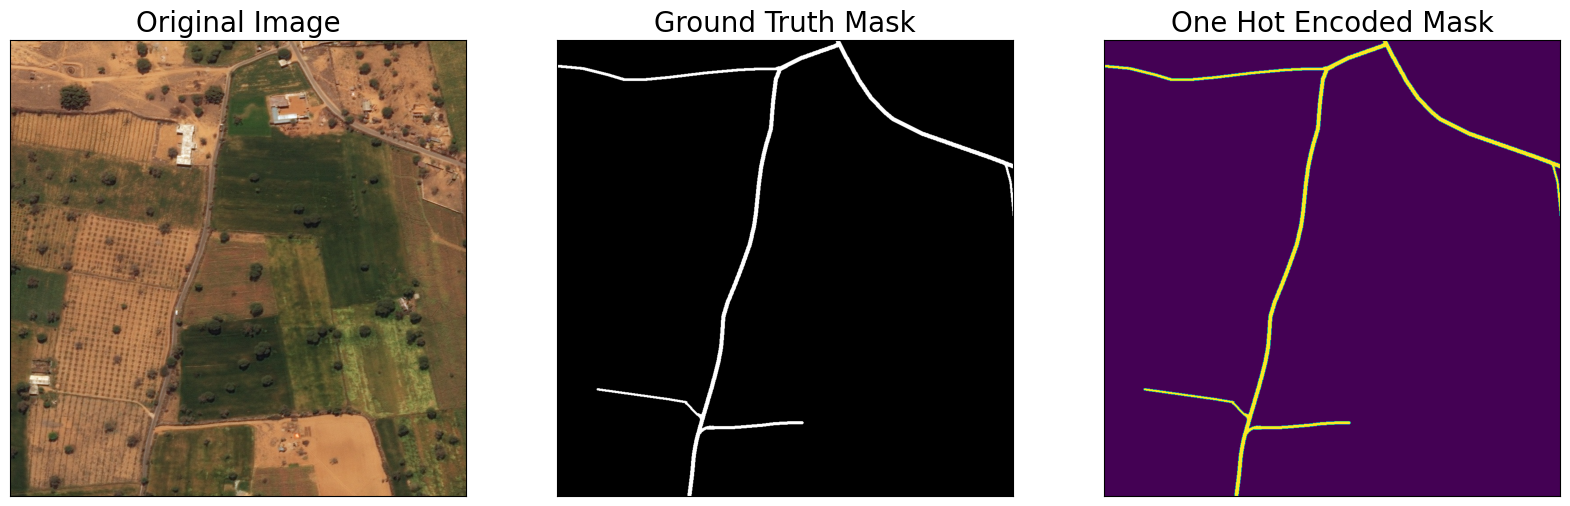

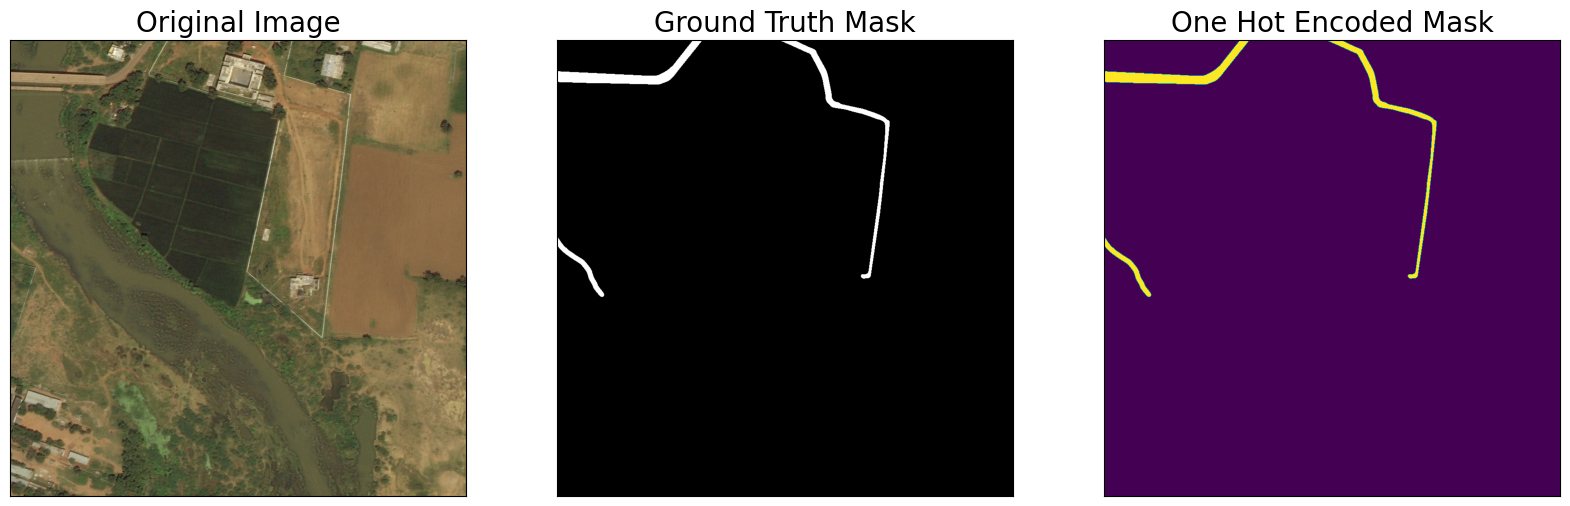

In [ ]:
augmented_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


In [ ]:
train_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

In [ ]:
valid_dataset = RoadsDataset(
    valid_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [ ]:
TRAINING = True

EPOCHS = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 156/156 [01:47<00:00,  1.46it/s, dice_loss - 0.03575, iou_score - 0.9433]
Model saved!

Epoch: 1
valid: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s, dice_loss - 0.02662, iou_score - 0.9539]
Model saved!

Epoch: 2
valid: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s, dice_loss - 0.0223, iou_score - 0.9585]
Model saved!
CPU times: user 1h 29min 26s, sys: 2min 56s, total: 1h 32min 22s
Wall time: 1h 51min 19s


In [ ]:
best_model = torch.load('./best_model.pth', map_location=DEVICE)
print('Loaded DeepLabV3+ model from this run.')

Loaded DeepLabV3+ model from this run.


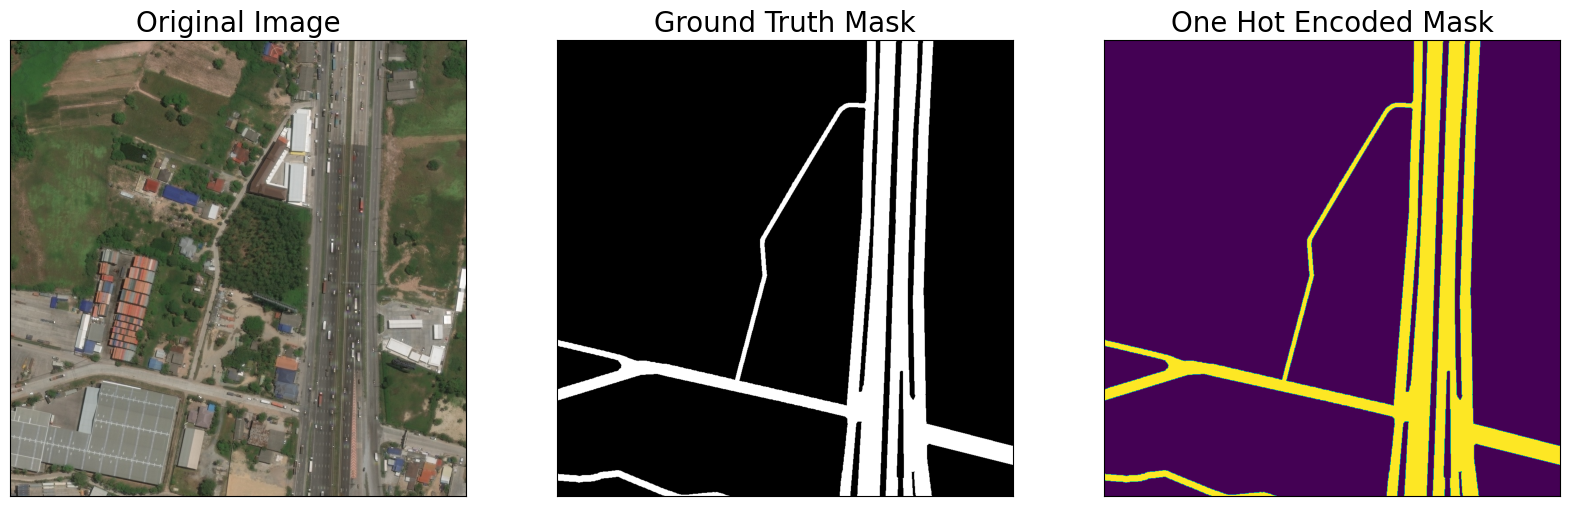

In [ ]:
test_dataset = RoadsDataset(
    valid_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

test_dataset_vis = RoadsDataset(
    valid_df,
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

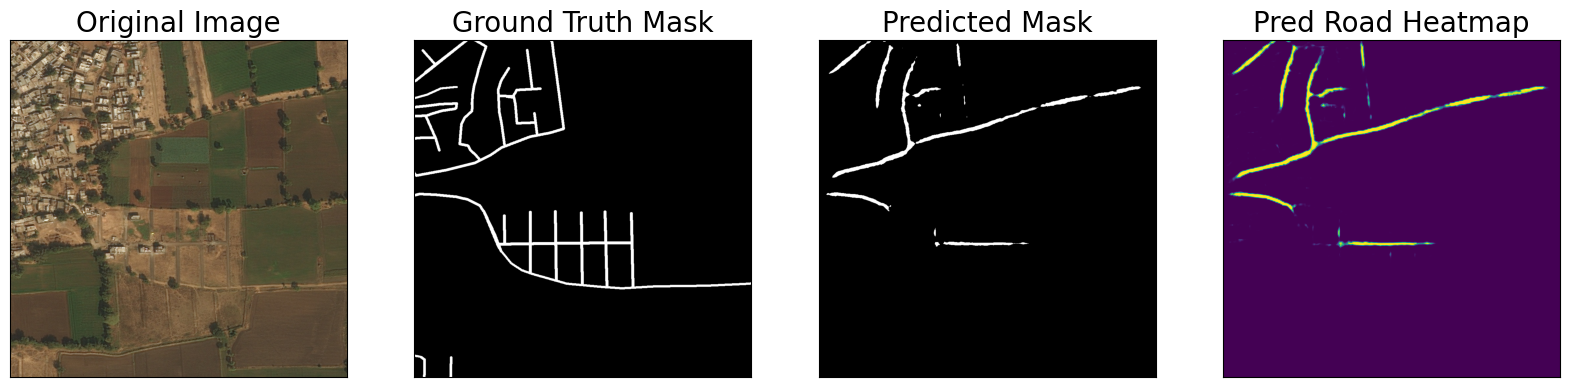

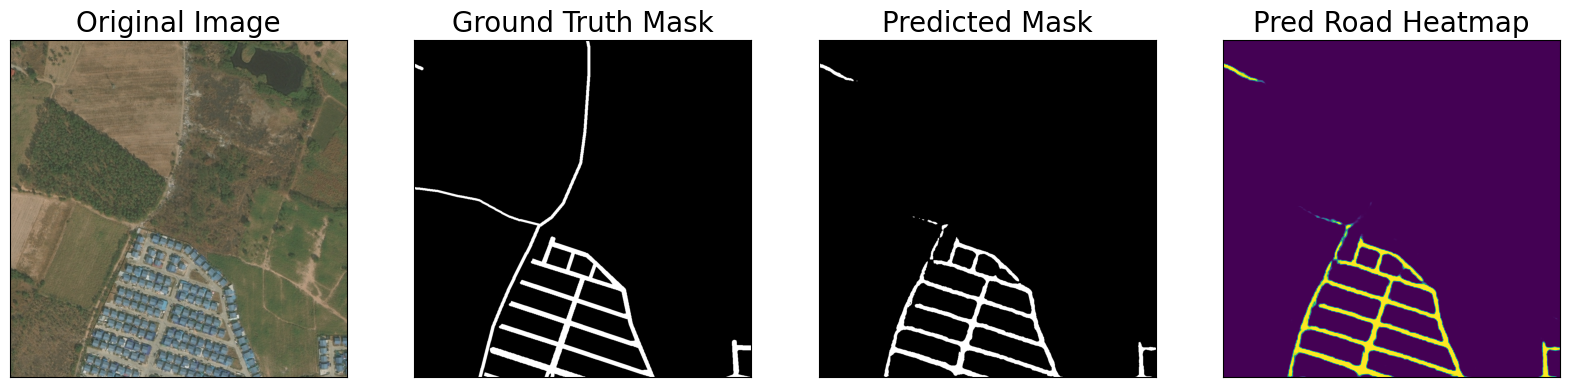

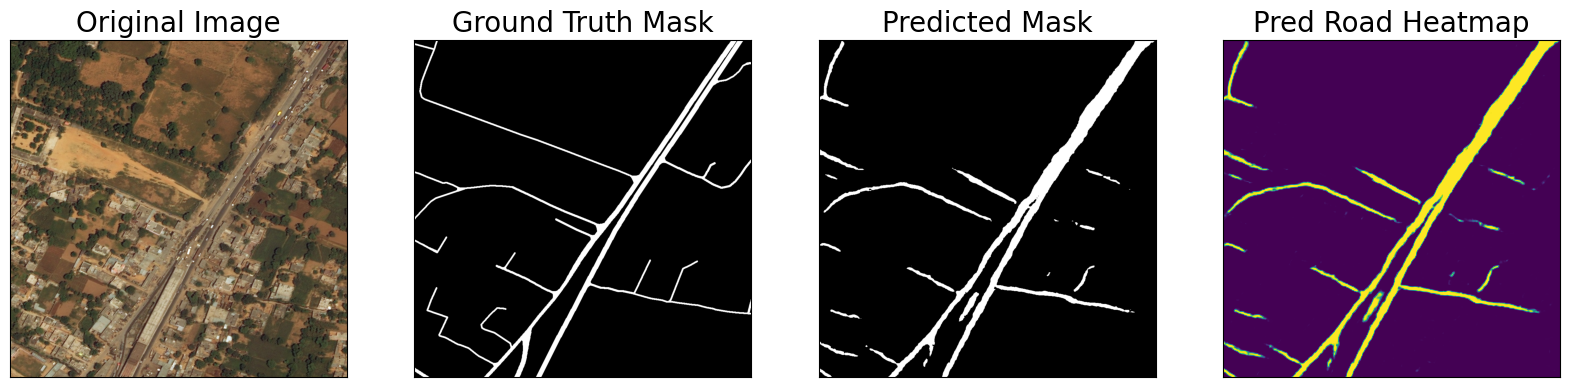

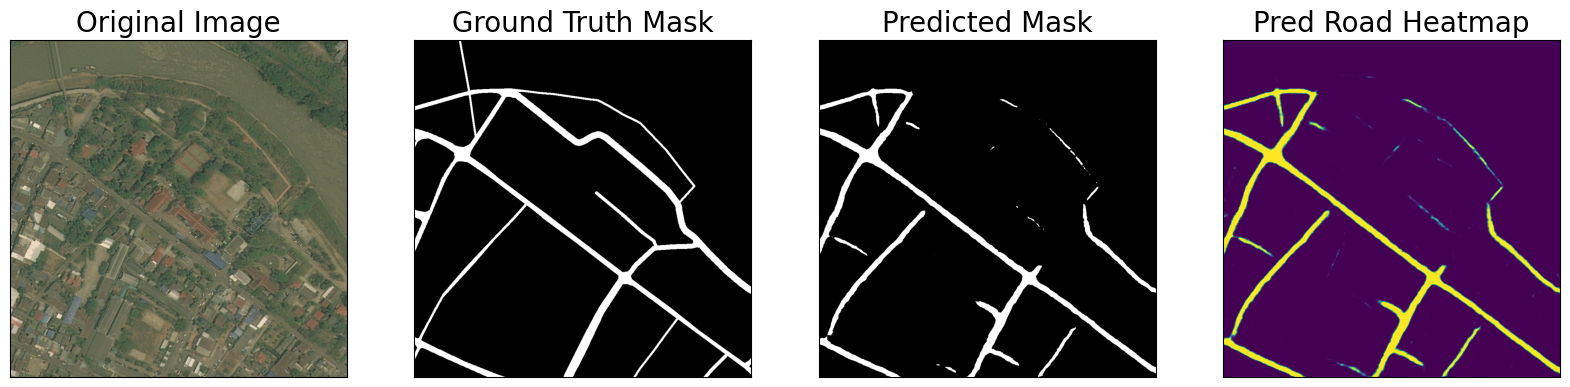

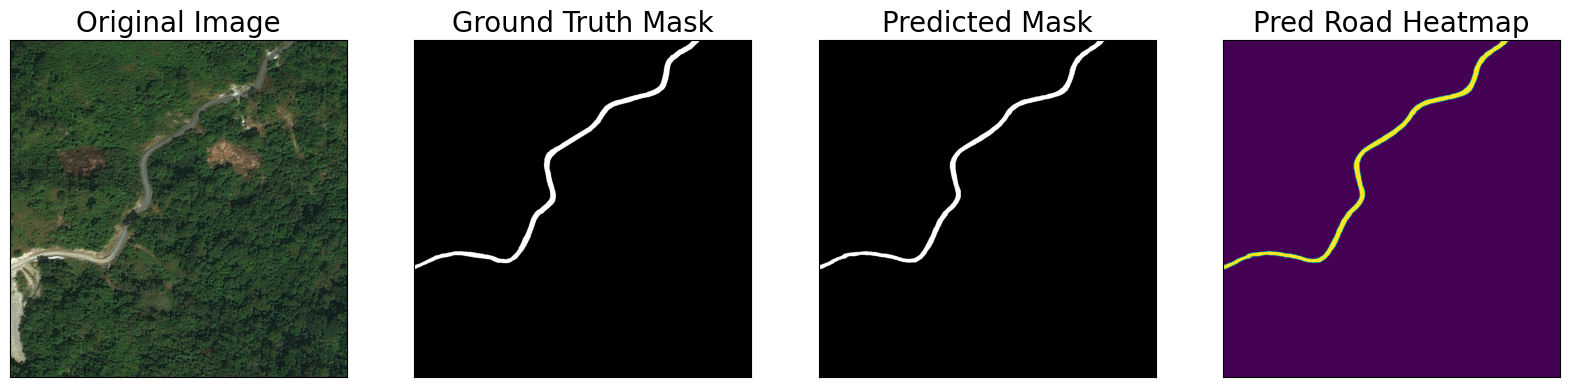

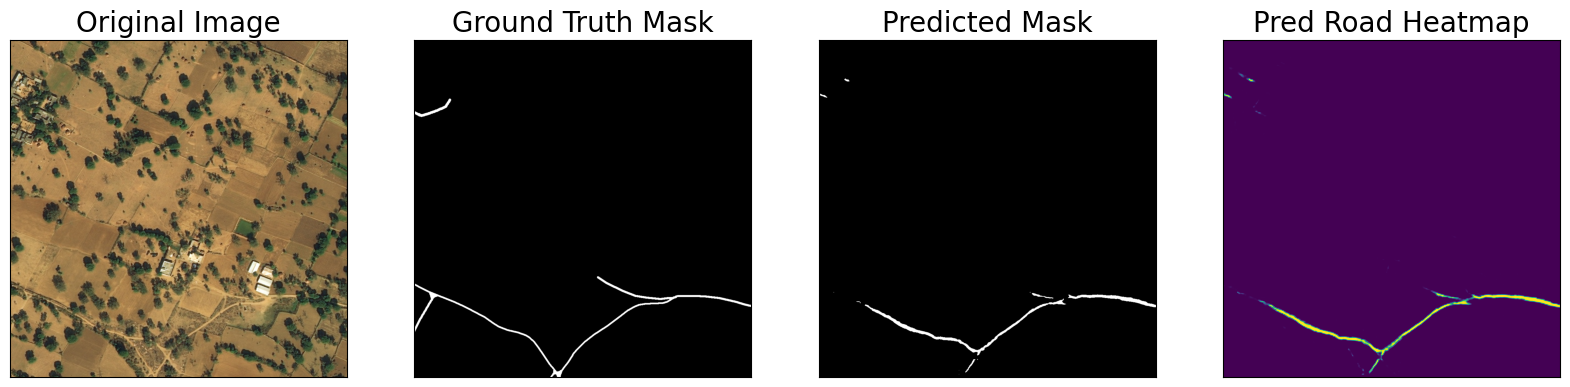

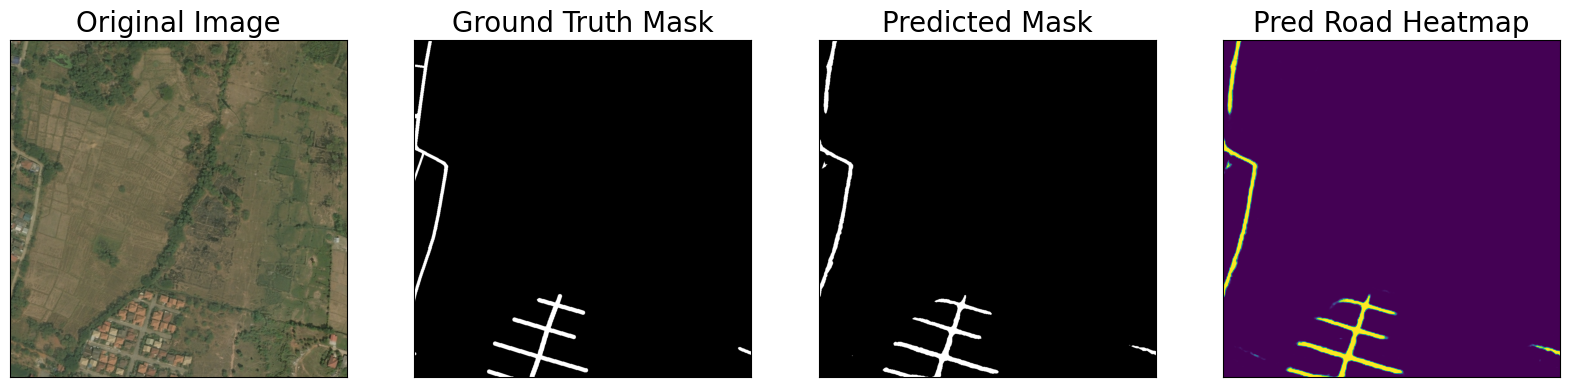

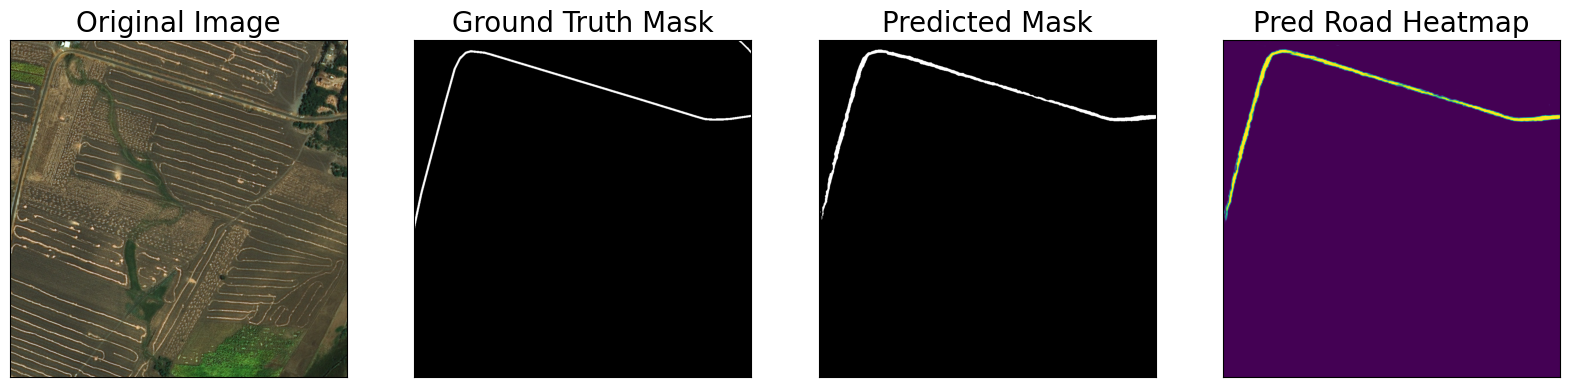

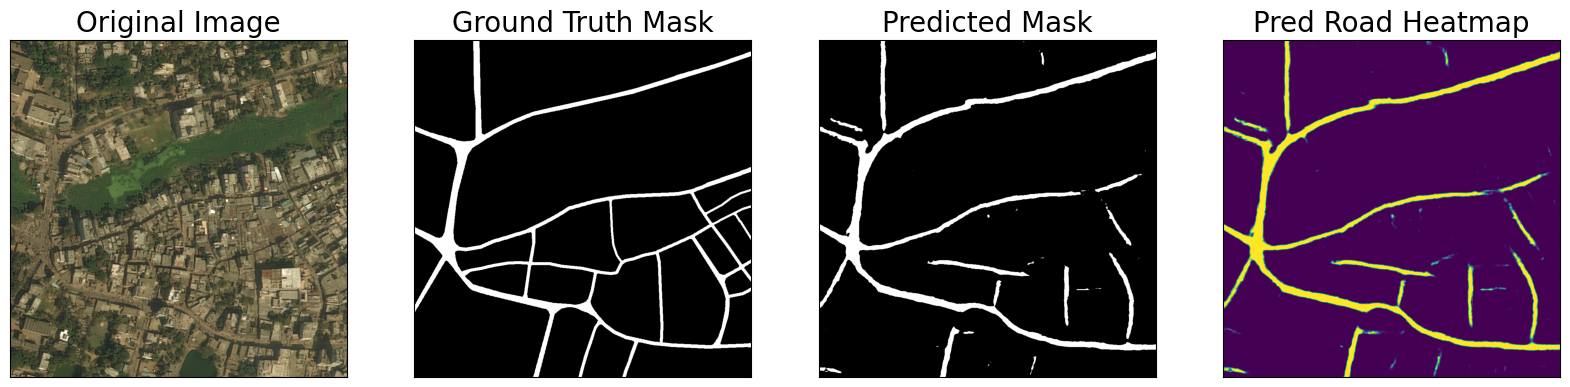

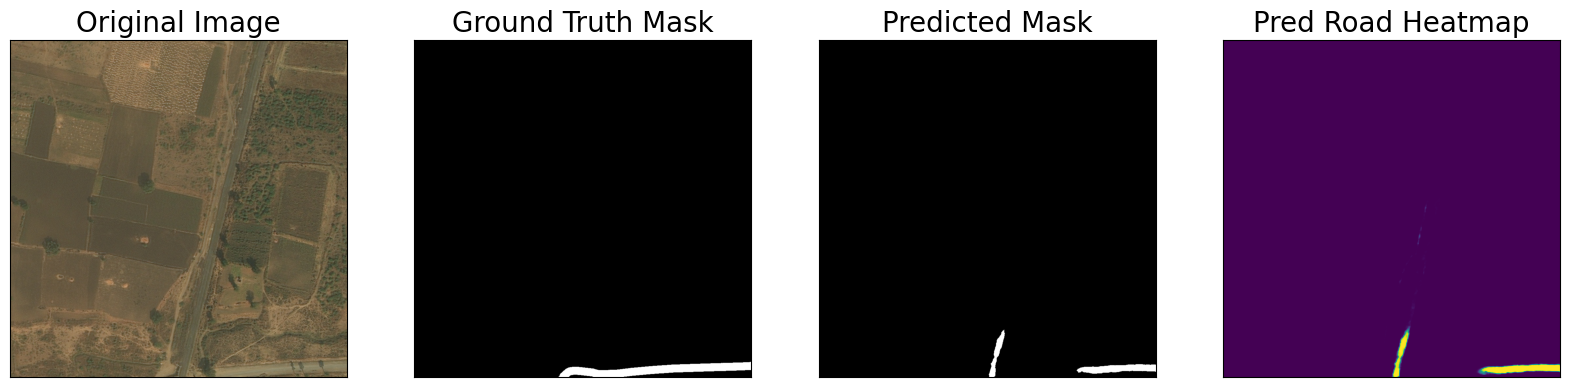

In [ ]:
for idx in range(10):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    pred_mask = np.transpose(pred_mask,(1,2,0))

    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_road_heatmap = pred_road_heatmap
    )

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 623/623 [02:56<00:00,  3.52it/s, dice_loss - 0.02231, iou_score - 0.959]
Evaluation on Test Data: 
Mean IoU Score: 0.9590
Mean Dice Loss: 0.0223


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2
dice_loss  0.084518  0.031237  0.025450
iou_score  0.919513  0.946702  0.953413

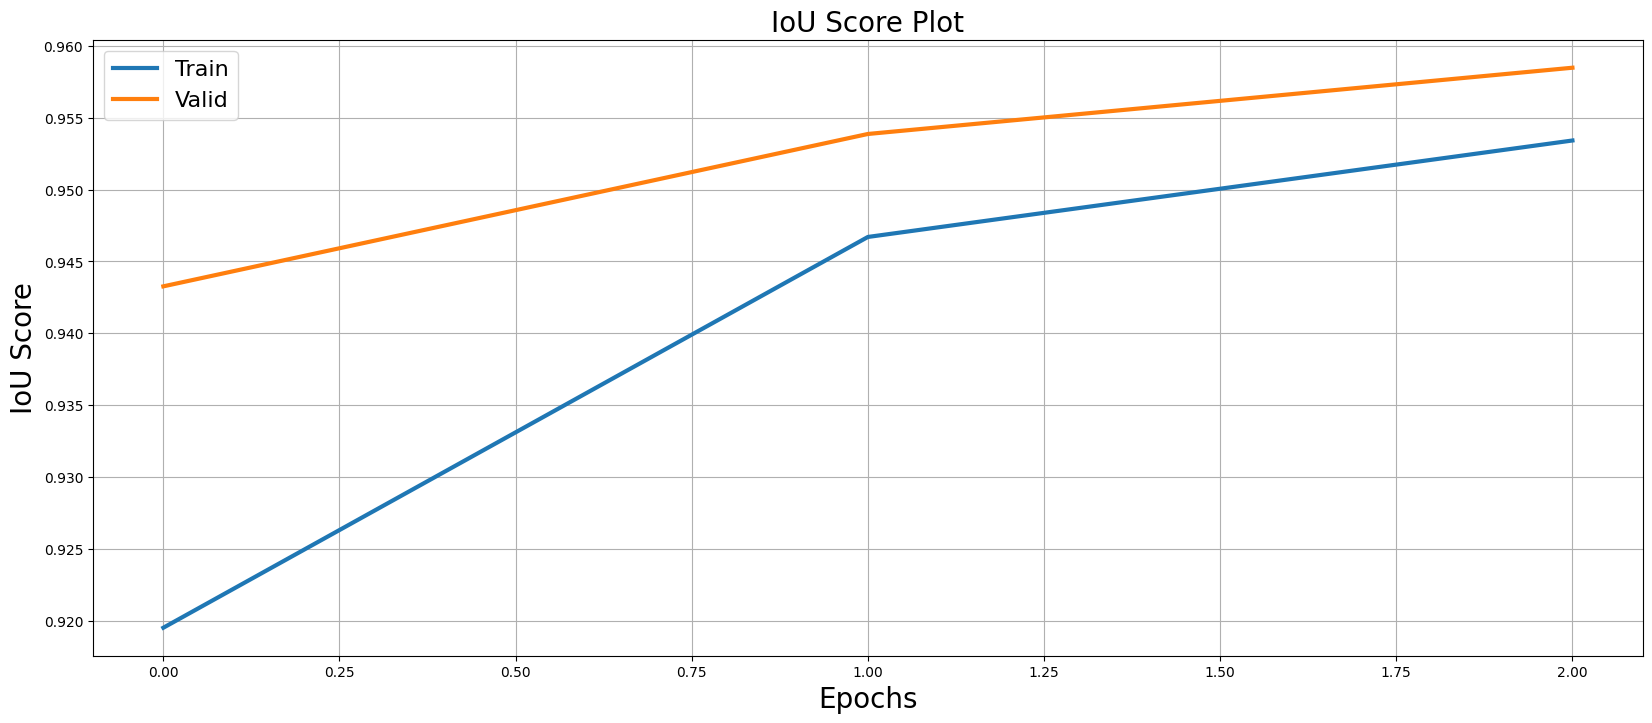

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

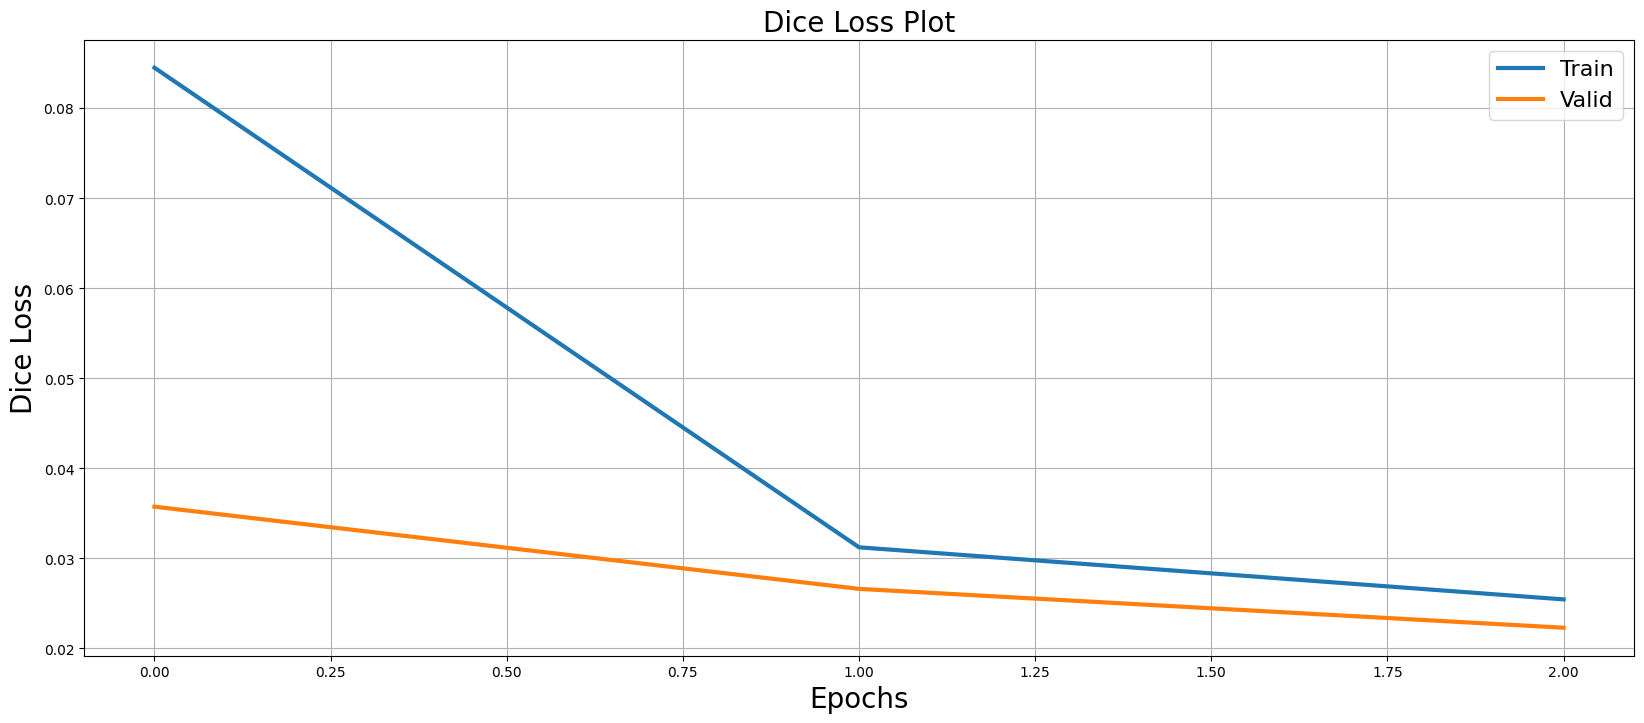

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()